In [75]:
%cd '/home/danbi/userdata/DANBI/gugakwon/Yeominrak'
%load_ext autoreload
%autoreload 2

from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore
from model import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from trainer import Trainer
from decode import MidiDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from metric import make_dynamic_template, convert_note_to_sampling, get_similarity, get_correspondence

/home/danbi/userdata/DANBI/gugakwon/Yeominrak
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)
device = 'cpu'
val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
state = torch.load('best_model.pt')
model.load_state_dict(state)

<All keys matched successfully>

### 단일

In [77]:
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate)
model.to('cpu')
val_part_idx_info = defaultdict(list)
for i, val in enumerate(val_dataset):
    val_part_idx_info[int(val[0][0][0])].append(i)
val_part_idx_info

defaultdict(list,
            {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
             1: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
             2: [28, 29, 30, 31, 32, 33, 34],
             3: [35, 36, 37, 38, 39, 40, 41],
             5: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
             6: [56, 57, 58, 59, 60, 61, 62]})

In [78]:

def get_similarity_with_inference(src, output, dynamic_templates):
  sampled_src = convert_note_to_sampling(src, dynamic_templates)
  smpled_output = convert_note_to_sampling(output, dynamic_templates)
  
  measure_similarity = sum([note_1[1]==note_2[1] for note_1, note_2 in zip(sampled_src, smpled_output)])/len(sampled_src)

  return measure_similarity

def get_correspondence_with_inference(src, output, dynamic_templates):
  sampled_src = convert_note_to_sampling(src, dynamic_templates)
  smpled_output = convert_note_to_sampling(output, dynamic_templates)
  strong_beat_a, strong_beat_b = [], []
  for j, note in enumerate(sampled_src):
    if note[3] in ['strong', 'middle']:
      strong_beat_a.append(note[1])
  for j, note in enumerate(smpled_output):
    if note[3] in ['strong', 'middle']:
      strong_beat_b.append(note[1])  
  measure_correspondence = sum([strong_beat_a[idx]==strong_beat_b[idx] for idx in range(len(strong_beat_a))])/len(strong_beat_a)
  return measure_correspondence

In [84]:
import matplotlib.pyplot as plt
valid_dataset_idx = 56
output_part_idx = 7

sample = valid_loader.dataset[valid_dataset_idx][0]
# src, output, attention_map = model.inference(sample, output_part_idx)ㅂ3ㄱ 
src, output, attention_map = model.shifted_inference(sample, output_part_idx)

decoder = MidiDecoder(valid_loader)
src_midi = decoder(src)
output_midi = decoder(output)

dynamic_templates = make_dynamic_template(offset_list=val_dataset.offset_list)
get_similarity_with_inference(src, output, dynamic_templates), get_correspondence(src, output, dynamic_templates)
# merged_midi = stream.Stream()
# for element in src_midi:
#     merged_midi.append(element)
# for element in output_midi:
#     merged_midi.append(element)

# merged_midi.write('musicxml.png', "source_and_output.png")

16 12


IndexError: list index out of range

In [88]:
val_dataset.offset_list

[4.0, 8.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

In [85]:
sum([note[2] for note in src]) == sum([note[2] for note in output]) 
  

False

In [87]:
[] + [True]+ [False] + [True]

[True, False, True]

## 순서대로!

In [81]:
valid_dataset_idx = 1
output_part_idx = 1
decoder = MidiDecoder(valid_loader)
merged_midi = stream.Stream()
sample = valid_loader.dataset[valid_dataset_idx][0]

for i in range(7):    
  src, output, attention_map = model.shifted_inference(sample, output_part_idx)
  if i == 0:
    src_midi = decoder(src)
    for element in src_midi:
      merged_midi.append(element)
  print(i)
  output_midi = decoder(output)
  for element in output_midi:
    merged_midi.append(element)
  pred, condition = [note[:3] for note in output], [note[3:] for note in output]
  output = [pred[0] + [0, 'strong', 0]] + [pr + con for pr, con in zip(pred[1:], condition[:-1])] + [[i+1, 'end', 'end', 'end', 'end', 'end']]
  output = [[i+1, 'start', 'start', 'start', 'start', 'start']] + output
  sample = [val_dataset.tokenizer(note) for note in output]
  sample = torch.Tensor(sample).long()
  print(sample)
  output_part_idx += 1

merged_midi.write('musicxml.png', "source_and_output.png")


# src, output, attention_map = model.inference(sample, output_part_idx)







0
tensor([[ 1,  1,  1,  1,  1,  1],
        [ 1,  5, 13,  3,  3,  3],
        [ 1,  4,  6, 19,  3,  3],
        [ 1,  5,  6, 22,  5,  3],
        [ 1,  4,  6, 25,  5,  3],
        [ 1,  6,  9,  3,  3,  4],
        [ 1,  5,  6,  7,  5,  4],
        [ 1,  4, 11, 11,  4,  4],
        [ 1,  4,  6, 22,  5,  4],
        [ 1,  4,  6, 25,  5,  4],
        [ 1, 11, 13,  3,  3,  5],
        [ 1, 11,  9, 19,  3,  5],
        [ 1, 13,  6, 25,  5,  5],
        [ 1, 11, 11,  3,  3,  6],
        [ 1, 11,  9, 11,  4,  6],
        [ 1, 11,  6, 19,  3,  6],
        [ 1, 11,  9, 22,  5,  6],
        [ 1,  2,  2,  2,  2,  2]])
1
tensor([[ 2,  1,  1,  1,  1,  1],
        [ 2,  5,  6,  3,  3,  3],
        [ 2,  5,  6,  5,  5,  3],
        [ 2,  5,  6,  7,  5,  3],
        [ 2,  4, 11, 11,  4,  3],
        [ 2,  5,  6, 22,  3,  3],
        [ 2,  4,  6, 25,  5,  3],
        [ 2,  5,  6, 29,  4,  3],
        [ 2,  5,  6, 32,  5,  3],
        [ 2,  6, 11,  3,  3,  4],
        [ 2,  6, 11, 11,  4,  4],
        [

4
tensor([[ 5,  1,  1,  1,  1,  1],
        [ 5,  5,  6,  3,  3,  3],
        [ 5,  5,  6,  5,  5,  3],
        [ 5,  7,  6,  7,  5,  3],
        [ 5,  6, 11, 11,  4,  3],
        [ 5,  5,  6, 22,  3,  3],
        [ 5,  4,  6, 25,  5,  3],
        [ 5,  5,  6, 29,  4,  3],
        [ 5,  7,  6, 32,  5,  3],
        [ 5,  6,  6,  3,  3,  4],
        [ 5,  6,  6,  5,  5,  4],
        [ 5,  7,  6,  7,  5,  4],
        [ 5,  6, 11, 11,  4,  4],
        [ 5,  5,  6, 22,  3,  4],
        [ 5,  4,  6, 25,  5,  4],
        [ 5,  5,  6, 29,  4,  4],
        [ 5,  7,  6, 32,  5,  4],
        [ 5,  6,  6,  3,  3,  5],
        [ 5,  6,  6,  5,  5,  5],
        [ 5,  4,  6,  7,  5,  5],
        [ 5,  6, 11, 11,  4,  5],
        [ 5,  5,  6, 22,  3,  5],
        [ 5,  4,  6, 25,  5,  5],
        [ 5,  5,  6, 29,  4,  5],
        [ 5,  7,  6, 32,  5,  5],
        [ 5,  6, 11,  3,  3,  6],
        [ 5,  6, 11, 11,  4,  6],
        [ 5,  6,  6, 22,  3,  6],
        [ 5,  5,  6, 25,  5,  6],
        [ 5,

PosixPath('/home/danbi/userdata/DANBI/gugakwon/Yeominrak/source_and_output-1.png')

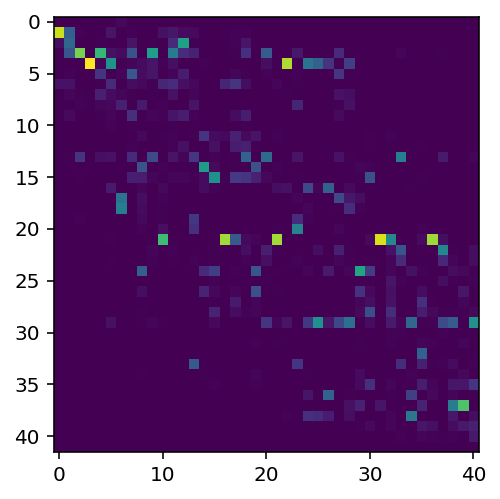

In [82]:
import matplotlib.pyplot as plt

plt.imshow(attention_map)

In [83]:
sample

tensor([[ 7,  1,  1,  1,  1,  1],
        [ 7,  5,  6,  3,  3,  3],
        [ 7,  7,  6,  5,  5,  3],
        [ 7,  7,  6,  7,  5,  3],
        [ 7,  7,  6, 11,  4,  3],
        [ 7,  3,  6, 15,  5,  3],
        [ 7,  7,  6, 19,  3,  3],
        [ 7,  6,  6, 22,  5,  3],
        [ 7,  7,  6, 25,  4,  3],
        [ 7,  6,  6, 29,  5,  3],
        [ 7,  7,  6, 32,  5,  3],
        [ 7,  5,  6,  3,  3,  4],
        [ 7,  7,  4,  5,  5,  4],
        [ 7,  5,  4,  6,  5,  4],
        [ 7,  4,  6,  7,  5,  4],
        [ 7,  6,  6, 11,  4,  4],
        [ 7,  6,  6, 15,  5,  4],
        [ 7,  5,  6, 19,  3,  4],
        [ 7,  6,  6, 22,  5,  4],
        [ 7,  7,  6, 25,  4,  4],
        [ 7,  6,  6, 29,  5,  4],
        [ 7,  7,  6, 32,  5,  4],
        [ 7,  7,  6,  3,  3,  5],
        [ 7,  7,  6,  5,  5,  5],
        [ 7,  4,  6,  7,  5,  5],
        [ 7,  7,  6, 11,  4,  5],
        [ 7,  7,  6, 15,  5,  5],
        [ 7,  7,  6, 19,  3,  5],
        [ 7,  7,  6, 22,  5,  5],
        [ 7,  